#                   Image Compression Using Singular Value Decomposition

(a) SVD using sci-kit learn library.

In [1]:

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

def compression_ratio(image,no_of_singularvalues):
    
    '''This function return compression ratio based on the formula 
       comprssion ratio = m*n/(k(1+m+n)) whre k is no .of dingular values
       and m is size of image(data)'''
    
    
    no_of_channels = image.shape[2]
    Original_memory = np.prod(image.shape)
    print("original memory:",Original_memory)
    m,n,c = image.shape
    Compressed_memory = ((1 + int(m)+ int(n))*no_of_singularvalues ) * no_of_channels
    print('Compressed_memory:',Compressed_memory)
    
    print(f'The compressed memory is roughly \
    {100 * Compressed_memory / Original_memory:0.0f}% of the original')
    
    return Original_memory/Compressed_memory

def MSE_nd_PSNR(image,compressed1,max_value=255):
    
    '''This function return the Mean square error and Peak signal to noise ratio'''
    
    #Vectorised equation for MSE calculation
    mean_square_error = np.square(np.subtract(image,compressed1)).mean()

    #err = np.sum((image.astype("float")-compressed1.astype("float"))**2)
    #mean_square_error = err/float(image.size)
    #image.max(axis=(0,1))
    #print(max_value)
    if(mean_square_error==0):
        PSNR = 100
    else:
        PSNR = 20*np.log10(max_value/(np.sqrt(mean_square_error)))
   
    return mean_square_error,PSNR
                                       
def compress_sklearn(imageIn, no_of_singularvalues=100):
    
    '''This function return compressed receives input image and no. of singular values 
       and returns compressed image accordingly.'''
    
    image = imageIn
    
    if len(image.shape) != 3: 
        raise('This function is for BGR images only!!')

        
    if image.shape[2] == 3:
        image_type = 'BGR'
        print('Found BGR image')
    
    no_of_channels = image.shape[2]
    compressed_channels_list = []
    
    for channel in range(no_of_channels):
        #print('channel',channel)
        #print(image[:,:,channel])
        image_channel = image[:,:,channel]  # ie r, g or b
        
        xyz = TruncatedSVD(n_components=no_of_singularvalues)
        xyz.fit(image_channel)
        xyz.transform(image_channel)
        compressed_channel = xyz.inverse_transform(xyz.transform(image_channel))
        
        #compressed_channel = xyz.inverse_transform(xyz.fit_transform(image_channel))
        #print('compressed_channel')
        #print(compressed_channel)
        compressed_channels_list.append(compressed_channel)
    #print('compressed_channels_list')
    #print(compressed_channels_list)
        
        
    compressed = np.stack(compressed_channels_list, axis=2)
    print('compressed')
    #print(compressed)
    if image_type =='BGR':
      # clip to expected range
      compressed = np.clip(compressed, a_min=0, a_max=255)
      
      # cast to same dtype as original image
    compressed = np.array(compressed, dtype = image.dtype)
    print(compressed.shape)
    # reshape to original image size
    #compressed = compressed.reshape(imageIn.shape)

    SHAPE = compressed.shape
    print('shape:', SHAPE)
    
    comp_ratio = compression_ratio(image,no_of_singularvalues)  
    print('Compression ratio is:',comp_ratio)

    Mean_square_error,PSNR = MSE_nd_PSNR(image,compressed)
    print('Mean square Error : ',Mean_square_error)
    print('Peak signal to noise ratio :{} decibals'.format(PSNR))
                                      
    return compressed

In [2]:
import cv2
import matplotlib.pyplot as plt   
import numpy as np


img1= plt.imread('C:\\Users\mayan\Downloads\Rose.jpg')    #Importing the image
img2= plt.imread('C:\\Users\mayan\Downloads\lena.tif')    #Importing the image


image_dict = {'rose':img1, 'lena': img2}           #Creating image dictionary

In [3]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(name=image_dict.keys(), 
          no_of_singularvalues=[1,2,5,10,20,50,100,200,400,470])

def plot_compressed(name,no_of_singularvalues=5):
    image = image_dict[name]
    print(name)
    compressed_image = compress_sklearn(image, no_of_singularvalues=no_of_singularvalues)
    
    fig, axis = plt.subplots(1,2 , figsize=(15, 8))

    axis[0].imshow(image)
    axis[0].set_title('Original Image')

    axis[1].imshow(compressed_image)
    axis[1].set_title('Compressed Image')
    return None

interactive(children=(Dropdown(description='name', options=('rose', 'lena'), value='rose'), Dropdown(descripti…

(b) SVD using numpy linear algebra library.

In [4]:
def SVDcompress(image,r):
    ''' This funtion uses only linear algebra library to implement
         SVD and image compression'''
    
    if len(image.shape) != 3: 
        raise('This function is for BGR images only!!')

        
    if image.shape[2] == 3:
        image_type = 'BGR'
        print('Found BGR image')

       
    no_of_channels = image.shape[2]
    compressed_channels_list = []
    
    for channel in range(no_of_channels):
        #print('channel',channel)
        #print(image[:,:,channel])
        image_channel = image[:,:,channel]
        
        # Svd of all channels
        U, S, VT = np.linalg.svd(image_channel,full_matrices=False)  #Compressed Data
        S = np.diag(S)
        # Reconstruction
        compressed_channel = U[:,:r] @ S[:r,:r] @ VT[:r,:]
        #print(compressed_channel)
        compressed_channels_list.append(compressed_channel)
        #print('compressed_channels_list')
        #print(compressed_channels_list)
        
        
    compressed_image = np.stack(compressed_channels_list, axis=2)
    #print('compressed')
    #print(compressed)
    if image_type =='BGR':
      # clip to expected range  
        compressed_image = np.clip(compressed_image, a_min=0, a_max=255)
        compressed_image = compressed_image.astype('int')
        
    SHAPE = compressed_image.shape
    print('shape:', SHAPE)
    
    comp_ratio1 = compression_ratio(image,r)
    print('Compression ratio is:',comp_ratio1)

    Mean_square_error,PSNR = MSE_nd_PSNR(image,compressed_image)
    print('Mean square Error : ',Mean_square_error)
    print('Peak signal to noise ratio :{} decibals'.format(PSNR))
    
    return compressed_image

In [5]:
@interact(name=image_dict.keys(), 
          no_of_singularvalues=[1,2,5,10,20,50,100,200,400])

def plot_compressed(name,no_of_singularvalues=5):
    image = image_dict[name]
    print(name)
    compressed_image = SVDcompress(image, r=no_of_singularvalues)
    
    
    fig, axis = plt.subplots(1,2 , figsize=(20, 8))

    axis[0].imshow(image)
    axis[0].set_title('Original Image')

    axis[1].imshow(compressed_image)
    axis[1].set_title('Compressed Image')
    
    return None

interactive(children=(Dropdown(description='name', options=('rose', 'lena'), value='rose'), Dropdown(descripti…

(c) Image compression using SVD from Scratch.

In [6]:
import numpy as np
from numpy.linalg import norm

from random import normalvariate
from math import sqrt


def randomUnitVector(n):
    unnormalized = [normalvariate(0, 1) for _ in range(n)]
    theNorm = sqrt(sum(x * x for x in unnormalized))
    return [x / theNorm for x in unnormalized]


def svd_1d(A, epsilon=1e-10):
    ''' The one-dimensional SVD '''

    n, m = A.shape
    x = randomUnitVector(min(n,m))
    lastV = None
    currentV = x

    if n > m:
        B = np.dot(A.T, A)
    else:
        B = np.dot(A, A.T)

    iterations = 0
    while True:
        iterations += 1
        lastV = currentV
        currentV = np.dot(B, lastV)
        currentV = currentV / norm(currentV)

        if abs(np.dot(currentV, lastV)) > 1 - epsilon:
            #print("converged in {} iterations!".format(iterations))
            return currentV

In [7]:
def svd(A, k=None, epsilon=1e-10):
    
    A = np.array(A, dtype=float)
    n, m = A.shape
    svdSoFar = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrixFor1D = A.copy()

        for singularValue, u, v in svdSoFar[:i]:
            matrixFor1D -= singularValue * np.outer(u, v)

        if n > m:
            v = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            u_unnormalized = np.dot(A, v)
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            v_unnormalized = np.dot(A.T, u)
            sigma = norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svdSoFar.append((sigma, u, v))

    singularValues, us, vs = [np.array(x) for x in zip(*svdSoFar)]
    return us.T,singularValues, vs

In [8]:
def SVD_scratch(image,r):
    
    # taking one channel at a time.
    if len(image.shape) != 3: 
        raise('This function is for BGR images only!!')

        
    if image.shape[2] == 3:
        image_type = 'BGR'
        print('Found BGR image')

       
    no_of_channels = image.shape[2]
    compressed_channels_list = []
    
    for channel in range(no_of_channels):
        #print('channel',channel)
        #print(image[:,:,channel])
        image_channel = image[:,:,channel]
        # Svd of all channels
        U, S, VT = svd(image_channel,r)
        S = np.diag(S)
        compressed_channel = U[:,:(r+1)] @ S[:(r+1),:(r+1)] @ VT[:(r+1),:]
        #print(compressed_channel)
         
        compressed_channels_list.append(compressed_channel)
        #print('compressed_channels_list')
        #print(compressed_channels_list)
        
        
    compressed_image = np.stack(compressed_channels_list, axis=2)
    #print('compressed')
    #print(compressed)
    if image_type =='BGR':
      # clip to expected range  
        compressed_image = np.clip(compressed_image, a_min=0, a_max=255)
        compressed_image = compressed_image.astype('int')
    
    SHAPE = compressed_image.shape
    print('shape:', SHAPE)
    
    comp_ratio1 = compression_ratio(image,r)
    print('Compression ratio is:',comp_ratio1)

    Mean_square_error,PSNR = MSE_nd_PSNR(image,compressed_image)
    print('Mean square Error : ',Mean_square_error)
    print('Peak signal to noise ratio :{} decibals'.format(PSNR))
    
    return compressed_image

In [9]:
import time
@interact(name=image_dict.keys(), 
          no_of_singularvalues=[1,2,5,10,20,50,100,200,400])

def plot_compressed(name,no_of_singularvalues=5):
    image = image_dict[name]
    print(name)
    t1 = time.time()
    compressed_image = SVD_scratch(image, r=no_of_singularvalues)
    t2 = time.time()-t1
    print("Time taken to return compressed image using SVD:", t2)
    fig, axis = plt.subplots(1,2 , figsize=(8, 8))

    axis[0].imshow(image)
    axis[0].set_title('Original Image')

    axis[1].imshow(compressed_image)
    axis[1].set_title('Compressed Image')
    
    return None

interactive(children=(Dropdown(description='name', options=('rose', 'lena'), value='rose'), Dropdown(descripti…

(d)Image copression using Randomised SVD (implemented using numpy linear algebra library)

In [10]:
def rSVD(X,r,q,p):
    # Step 1: Sample column space of X with P matrix
    ny = X.shape[1]
    P = np.random.randn(ny,r+p)
    Z = X @ P
    for k in range(q):
        Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z,mode='reduced')

    # Step 2: Compute SVD on projected Y = Q.T @ X
    Y = Q.T @ X
    UY, S, VT = np.linalg.svd(Y,full_matrices=0)
    U = Q @ UY

    return U, S, VT

In [11]:
def rSVDcompress(image,r,q,p):
    # taking one channel at a time.
    if len(image.shape) != 3: 
        raise('This function is for BGR images only!!')

        
    if image.shape[2] == 3:
        image_type = 'BGR'
        print('Found BGR image')

       
    no_of_channels = image.shape[2]
    compressed_channels_list = []
    
    for channel in range(no_of_channels):
        #print('channel',channel)
        #print(image[:,:,channel])
        image_channel = image[:,:,channel]
        # Svd of all channels
        U, S, VT = rSVD(image_channel,r,q,p) 
        S = np.diag(S)
        compressed_channel = U[:,:r] @ S[:r,:r] @ VT[:r,:]
        #print(compressed_channel)
        compressed_channels_list.append(compressed_channel)
        #print('compressed_channels_list')
        #print(compressed_channels_list)
        
        
    compressed_image = np.stack(compressed_channels_list, axis=2)
    #print('compressed')
    #print(compressed)
    if image_type =='BGR':
      # clip to expected range  
        compressed_image = np.clip(compressed_image, a_min=0, a_max=255)
        compressed_image = compressed_image.astype('int')
    
    SHAPE = compressed_image.shape
    print('shape:', SHAPE)
    
    comp_ratio1 = compression_ratio(image,r)
    print('Compression ratio is:',comp_ratio1)

    Mean_square_error1,PSNR1 = MSE_nd_PSNR(image,compressed_image)
    print('Mean square Error : ',Mean_square_error1)
    print('Peak signal to noise ratio :{} decibals'.format(PSNR1))
    
    return compressed_image

In [12]:

@interact(name=image_dict.keys(), 
          no_of_singularvalues=[1,2,5,10,20,50,100,200,400],p=[10,5],q=[1,2,3])

def plot_compressed(name,no_of_singularvalues=5,p=5,q=1):
    image = image_dict[name]
    print(name)
    
    # q=  Power iterations
    # p = Oversampling parameter
    compressed_image = rSVDcompress(image, r=no_of_singularvalues,p=p,q=q)
    
    
    fig, axis = plt.subplots(1,2 , figsize=(20, 8))

    axis[0].imshow(image)
    axis[0].set_title('Original Image')

    axis[1].imshow(compressed_image)
    axis[1].set_title('Compressed Image')
    
    return None

interactive(children=(Dropdown(description='name', options=('rose', 'lena'), value='rose'), Dropdown(descripti…

(e) Image compression using Randomised SVD (implemented from scratch)

In [13]:
def rSVD(X,r,q,p):
    # Step 1: Sample column space of X with P matrix
    ny = X.shape[1]
    P = np.random.randn(ny,r+p)
    Z = X @ P
    for k in range(q):
        Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z,mode='reduced')

    # Step 2: Compute SVD on projected Y = Q.T @ X
    Y = Q.T @ X
    UY, S, VT = svd(Y,r)
    U = Q @ UY

    return U, S, VT

In [14]:
def rSVD_scratch(image,r,q,p):
    # taking one channel at a time.
    if len(image.shape) != 3: 
        raise('This function is for BGR images only!!')

        
    if image.shape[2] == 3:
        image_type = 'BGR'
        print('Found BGR image')

       
    no_of_channels = image.shape[2]
    compressed_channels_list = []
    
    for channel in range(no_of_channels):
        #print('channel',channel)
        #print(image[:,:,channel])
        image_channel = image[:,:,channel]
        # Svd of all channels
        U, S, VT = rSVD(image_channel,r,q,p) 
        S = np.diag(S)
        compressed_channel = U[:,:r] @ S[:r,:r] @ VT[:r,:]
        #print(compressed_channel)
        compressed_channels_list.append(compressed_channel)
        #print('compressed_channels_list')
        #print(compressed_channels_list)
        
        
    compressed_image = np.stack(compressed_channels_list, axis=2)
    #print('compressed')
    #print(compressed)
    if image_type =='BGR':
      # clip to expected range  
        compressed_image = np.clip(compressed_image, a_min=0, a_max=255)
        compressed_image = compressed_image.astype('int')
    
    SHAPE = compressed_image.shape
    print('shape:', SHAPE)
    
    comp_ratio1 = compression_ratio(image,r)
    print('Compression ratio is:',comp_ratio1)

    Mean_square_error1,PSNR1 = MSE_nd_PSNR(image,compressed_image)
    print('Mean square Error : ',Mean_square_error1)
    print('Peak signal to noise ratio :{} decibals'.format(PSNR1))
    
    return compressed_image

In [15]:
import time
@interact(name=image_dict.keys(), 
          no_of_singularvalues=[1,2,5,10,20,50,100,200,400],p=[10,5],q=[1,2,3])

def plot_compressed(name,no_of_singularvalues=5,p=5,q=1):
    image = image_dict[name]
    print(name)
    
    # q=  Power iterations
    # p = Oversampling parameter
    t1 = time.time()
    compressed_image = rSVD_scratch(image, r=no_of_singularvalues,p=p,q=q)
    t2 = time.time() - t1
    print("Time taken to return compressed image using rSVD:", t2)
    fig, axis = plt.subplots(1,2 , figsize=(20, 8))

    axis[0].imshow(image)
    axis[0].set_title('Original Image')

    axis[1].imshow(compressed_image)
    axis[1].set_title('Compressed Image')
    
    return None


interactive(children=(Dropdown(description='name', options=('rose', 'lena'), value='rose'), Dropdown(descripti…

Illustration of power iterations effect on SVD

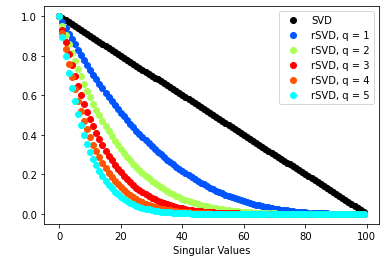

In [24]:
## Illustrate power iterations
X = np.random.randn(1000,100)
U, S, VT = np.linalg.svd(X,full_matrices=0)
S = np.arange(1,0,-0.01)
X = U @ np.diag(S) @ VT

color_list = np.array([[0,0,2/3],  # Define color map
                 [0,0,1],
                 [0,2/3,1],
                 [0,1/3,1],
                 [2/3,0,0],
                 [2/3,1,1/3],
                 [1/3,1,2/3],
                 [1,0,0],
                 [1,2/3,0],
                 [1,1/3,0],
                 [1,1,0],
                 [0,1,1]])

plt.plot(S,'o',color='k',LineWidth=2,label='SVD')

Y = X
for q in range(1,6):
    Y = X.T @ Y
    Y = X @ Y
    Uq, Sq, VTq = np.linalg.svd(Y,full_matrices=0)
    plt.plot(Sq,'o',color=tuple(color_list[2*q+1]),LineWidth=2,label='rSVD, q = '+str(q))

plt.legend()
plt.ylabel(" ")
plt.xlabel("Singular Values")
plt.show()

Plotting Processing times for SVD and rSVD from scratch functions

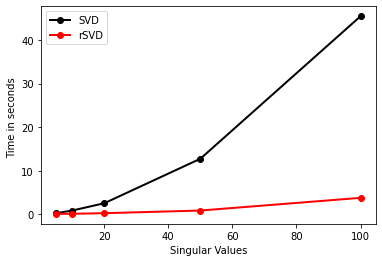

In [17]:
k= [5,10,20,50,100] # Singular Values
# *** processing times may vary on each function call , but for
# analysis purpose , these are taken at exact same time in same conditions
# and are subjected to the method used to generate SVD not to rSVD or SVD.
# But relatuvely whatever may be the method to evaluate SVD it will take
# lesser time always if we go for randomised SVD.

trSVD = [0.120,0.153,0.287, 0.896,3.805]
tSVD = [0.292,0.895,2.565,12.768,45.450]

plt.plot(k,tSVD,'-o',color ='k', LineWidth =2 , label ='SVD')
plt.plot(k,trSVD,'-o',color = 'r',LineWidth =2,label = 'rSVD')
plt.legend()
plt.ylabel("Time in seconds ")
plt.xlabel("Singular Values")
plt.show()